In [1]:
import os
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numba import jit
import pygmo as pg

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
funcs = {"sphere": 0, "schwefel": 1, "rosenbrock": 2, "rastrigin": 3, "griewank": 4, "ackley": 5}
funcs_dispname = {"sphere": "F1 : Shifted Sphere Function", 
                  "schwefel": "F2 : Schwefel’s Problem 2.21",
                  "rosenbrock": "F3 : Shifted Rosenbrock’s Function",
                  "rastrigin": "F4 : Shifted Rastrigin’s Function",
                  "griewank": "F5 : Shifted Griewank’s Function",
                  "ackley": "F6 : Shifted Ackley’s Function"}

In [3]:
def read_values(func):
    val_path = os.path.join('../data/', func_name + '.csv')
    bias_path = '../data/f_bias.csv'
    ss_path = '../data/search_space.csv'
    
    func_df = pd.read_csv(val_path)
    bias_df = pd.read_csv(bias_path)
    searchspace_df = pd.read_csv(ss_path)

    funcval = func_df.fvalue.values
    funcbias = bias_df.fvalue.values[funcs[func_name]]
    search_space = list(searchspace_df.iloc[funcs[func_name],])
    return funcval, funcbias, search_space

In [4]:
# function evaluation definitions

@jit(nopython=True)
def eval_fitness(x, dim):
    if func_name == "sphere":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z * z
        result = F + funcbias
    elif func_name == "schwefel":
        F = abs(x[0])
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F = max(F, abs(z))
        result = F + funcbias
    elif func_name == "rosenbrock":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z * z
        result = F + funcbias
    elif func_name == "rastrigin":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z ** 2 - 10 * math.cos(2 * math.pi * z) + 10
        result = F + funcbias
    elif func_name == "griewank":
        F1 = 0
        F2 = 1
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F1 += z ** 2 / 4000
            F2 += math.cos(z / math.sqrt(i + 1))
        result = F1 - F2 + 1 + funcbias
    elif func_name == "ackley":
        Sum1 = 0
        Sum2 = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            Sum1 += z ** 2
            Sum2 += math.cos(2 * math.pi * z)
        result = -20 * math.exp(-0.2 * math.sqrt(Sum1 / dim)) - math.exp(Sum2 / dim) + 20 + math.e + funcbias
    else:
        result = 0
    
    return result

In [5]:
# Define UDP problem Class

class My_problem:
    def __init__(self, dim, bounds, glob_opt):
        self.lower_bound = bounds[0]
        self.upper_bound = bounds[1]
        self.dimension = dim
        self.fitness_per_eval = []
        self.glob_opt = glob_opt

    def fitness(self, x):
        result = eval_fitness(x, self.dimension)
        return [result]

    def get_bounds(self):
        x_min = self.lower_bound * np.ones(self.dimension)
        x_max = self.upper_bound * np.ones(self.dimension)
        return x_min, x_max

In [6]:
# function to run selected algorithm on defined problem

def solve_pb(dim, my_algo, bounds, optim, popsize):
    prob = pg.problem(My_problem(dim, bounds, optim))
    pop = pg.population(prob, popsize)

    my_algo.set_verbosity(1)

    t1 = time.time()
    pop = my_algo.evolve(pop)
    t2 = time.time()

    time_diff = t2-t1
    
    if my_algo.get_name().split(":")[0] == "PSO":
        extract_algo = my_algo.extract(pg.pso)
    elif my_algo.get_name().split(":")[0] == "GACO":
        extract_algo = my_algo.extract(pg.gaco)
    elif my_algo.get_name().split(":")[0] == "DE":
        extract_algo = my_algo.extract(pg.de)
    elif my_algo.get_name().split(":")[0] == "saDE":
        extract_algo = my_algo.extract(pg.sade)
    elif my_algo.get_name().split(":")[0] == "IHS":
        extract_algo = my_algo.extract(pg.ihs)
    elif my_algo.get_name().split(":")[0] == "SGA":
        extract_algo = my_algo.extract(pg.sga)
    elif my_algo.get_name().split(":")[0] == "ABC":
        extract_algo = my_algo.extract(pg.bee_colony)
    
    log = extract_algo.get_log()
    curve = [x[2] for x in log]
    niter = log[-1][0]
    
    return pop, curve, niter, time_diff

In [57]:
# function to make print report of function solving

def print_solution(dimension, my_algo, pop_evolved, log, niter, duration):
    algorithm_name = my_algo.get_name()
    parameters = my_algo.get_extra_info()
    solution_x = pop_evolved.champion_x
    fitness = pop_evolved.champion_f[0]-funcbias
    n_evals = pop_evolved.problem.get_fevals()
    
    print("Function: %s" % funcs_dispname[func_name])
    print("Problem dimension: %d" % dimension)
    print("Search Space : ", search_space)
    print("Global Optimum: %.2f\n" % funcbias)
    print("Algorithm: %s" % algorithm_name)
    print("Parameters: \n%s\n" % parameters)
    print("Fitness: %f" % fitness)
    print("Solution: ")
    with pd.option_context('display.max_rows',10):
        print(pd.DataFrame(solution_x, columns=['X']))
    print("\nNb of functions evaluations: %d" % n_evals)
    print("Stopping criterion: after %d iterations" % niter)
    print("computational time: %.3f seconds" % duration)

    plt.plot(log)
    plt.xlabel("iterations")
    plt.ylabel("fitness: f(x)-f(x*)")
    plt.show()

In [55]:
# define algorithm and parameters to use

algo = pg.algorithm(pg.pso(gen=2000))
pop_size = 150

# algo = pg.algorithm(pg.gaco(gen=500))
# pop_size = 150

# algo = pg.algorithm(pg.de(gen=500))
# pop_size = 150

# algo = pg.algorithm(pg.sga(gen=500))
# pop_size = 150

# algo = pg.algorithm(pg.bee_colony(gen=500))
# pop_size = 150

# algo = pg.algorithm(pg.sade(gen=500))
# pop_size = 150

# algo = pg.algorithm(pg.ihs(gen=500))
# pop_size = 150

In [53]:
# select function of problem to be solved

# function to choose: sphere, schwefel, rosenbrock, rastrigin, griewank, ackley
func_name = 'schwefel'


Function: F2 : Schwefel’s Problem 2.21
Problem dimension: 50
Search Space :  [-100, 100]
Global Optimum: -450.00

Algorithm: PSO: Particle Swarm Optimization
Parameters: 
	Generations: 2000
	Omega: 0.7298
	Eta1: 2.05
	Eta2: 2.05
	Maximum velocity: 0.5
	Variant: 5
	Topology: 2
	Topology parameter: 4
	Memory: false
	Seed: 2502844314
	Verbosity: 1

Fitness: 13.443949
Solution: 
            X
0  -13.443949
1   -1.076674
2  -61.014389
3  -99.995143
4    5.801343
..        ...
45 -92.119087
46 -10.074831
47 -79.061903
48 -35.592300
49 -74.359944

[50 rows x 1 columns]

Nb of functions evaluations: 300150
Stopping criterion: after 2000 iterations
computational time: 3.604 seconds


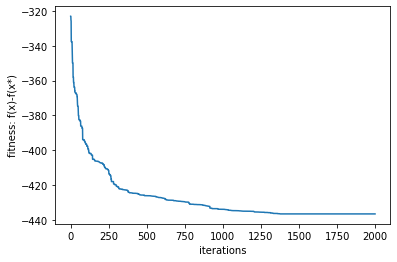

In [58]:
# run algorithm and print solution
DIM = 50
funcval, funcbias, search_space = read_values(func_name)
pop_evolv, logs, nit, compute_time = solve_pb(dim=DIM, my_algo=algo, bounds=search_space, optim=funcbias, popsize=pop_size)
print_solution(dimension=DIM, my_algo=algo, pop_evolved=pop_evolv, log=logs, niter=nit, duration=compute_time)
